# Working with large data volumes

> Abstract: Some strategies for requesting and handling larger data volumes

Note that the code could take a long time to run, so it is better to adjust it for smaller jobs if you are just testing it out.

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.6
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
import os
import glob

from viresclient import SwarmRequest
import datetime as dt
import pandas as pd
import xarray as xr

In [3]:
# Revert to non-html preview for xarray
#  to avoid extra long outputs of the .attr Sources
xr.set_options(display_style="text");

## Set up the request parameters

We specify the nominal scalar measurements (`F`) from the MAGxLR (1Hz) data product, subsampled to 5s. You may want to additionally set some magnetic model evaluation and filter according to the values of other parameters.

In [4]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")  # Swarm Alpha
request.set_products(
    measurements=["F",],
    # Choose between the full CHAOS model (will be a lot slower due to the MMA parts)
#     models=["CHAOS = 'CHAOS-6-Core' + 'CHAOS-6-Static' + 'CHAOS-6-MMA-Primary' + 'CHAOS-6-MMA-Secondary'"],
    # ...or just the core part:
#     models=["CHAOS = 'CHAOS-Core'"],
    sampling_step="PT5S"
)
# Quality Flags
# https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#label-Flags_F-and-Flags_B-Values-of-MDR_MAG_LR
# NB: will need to do something different for Charlie because the ASM broke so Flags_F are bad
request.set_range_filter("Flags_F", 0, 1)
# request.set_range_filter("Flags_B", 0, 1)
# # Magnetic latitude filter
# request.set_range_filter("QDLat", 70, 90)

Look at one day to see what the output data will look like:

In [5]:
data = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2014,1,2)
)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.703MB)

In [6]:
data.as_xarray()

<xarray.Dataset>
Dimensions:     (Timestamp: 17040)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-01T23:59:55
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Radius      (Timestamp) float64 6.878e+06 6.878e+06 ... 6.88e+06 6.88e+06
    Longitude   (Timestamp) float64 -14.12 -14.12 -14.13 ... 0.502 1.072 1.685
    Latitude    (Timestamp) float64 -1.229 -1.546 -1.863 ... -81.46 -81.76
    F           (Timestamp) float64 2.287e+04 2.284e+04 ... 3.829e+04 3.848e+04
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_060...
    MagneticModels:  []
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0']

## A) Fetch one year of data directly

Note that viresclient automatically splits the data into multiple sequential requests.

In [7]:
data = request.get_between(
    start_time=dt.datetime(2014,1,1),
    end_time=dt.datetime(2015,1,1)
)

          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (170.05MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (80.111MB)

The downloaded data is stored within a number of temporary CDF files according to the number of requests that were made. viresclient can still attempt to load this data directly, but depending on the data volume, you might run out of memory.

In [8]:
data.as_xarray()

<xarray.Dataset>
Dimensions:     (Timestamp: 6098883)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-12-31T23:59:55
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Radius      (Timestamp) float64 6.878e+06 6.878e+06 ... 6.83e+06 6.83e+06
    Longitude   (Timestamp) float64 -14.12 -14.12 -14.13 ... -147.2 -147.2
    Latitude    (Timestamp) float64 -1.229 -1.546 -1.863 ... 52.68 52.36 52.04
    F           (Timestamp) float64 2.287e+04 2.284e+04 ... 4.229e+04 4.216e+04
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_060...
    MagneticModels:  []
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0']

Without loading the data into memory, you can still find the temporary files on disk - their locations can be revealed by digging into the `data.contents` list, **but this is not recommended**:

In [9]:
data.contents[0]._file.name

'/tmp/vires_7s7siowy'

## B) Tune the size of requests

We can use [pandas.date_range](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) to generate a sequence of intervals to use and then sequentially create data files for each interval.

In [10]:
# Monthly start times
dates = pd.date_range(start="2014-1-1", end="2015-1-1", freq="MS").to_pydatetime()
start_times = dates[:-1]
end_times = dates[1:]
list(zip(start_times, end_times))

[(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2014, 2, 1, 0, 0)),
 (datetime.datetime(2014, 2, 1, 0, 0), datetime.datetime(2014, 3, 1, 0, 0)),
 (datetime.datetime(2014, 3, 1, 0, 0), datetime.datetime(2014, 4, 1, 0, 0)),
 (datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2014, 5, 1, 0, 0)),
 (datetime.datetime(2014, 5, 1, 0, 0), datetime.datetime(2014, 6, 1, 0, 0)),
 (datetime.datetime(2014, 6, 1, 0, 0), datetime.datetime(2014, 7, 1, 0, 0)),
 (datetime.datetime(2014, 7, 1, 0, 0), datetime.datetime(2014, 8, 1, 0, 0)),
 (datetime.datetime(2014, 8, 1, 0, 0), datetime.datetime(2014, 9, 1, 0, 0)),
 (datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2014, 10, 1, 0, 0)),
 (datetime.datetime(2014, 10, 1, 0, 0), datetime.datetime(2014, 11, 1, 0, 0)),
 (datetime.datetime(2014, 11, 1, 0, 0), datetime.datetime(2014, 12, 1, 0, 0)),
 (datetime.datetime(2014, 12, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0))]

In [11]:
# Generate file names to use
filenames = [f"data_{start.strftime('%Y-%m-%d')}.cdf" for start in start_times]
# Loop through each pair of times, and write the data to a file
for start, end, filename in zip(start_times, end_times, filenames):
    # Use show_progress=False to disable the progress bars
    data = request.get_between(start, end, show_progress=False)
    data.to_file(filename, overwrite=True)

Data written to data_2014-01-01.cdf


Data written to data_2014-02-01.cdf


Data written to data_2014-03-01.cdf


Data written to data_2014-04-01.cdf


Data written to data_2014-05-01.cdf


Data written to data_2014-06-01.cdf


Data written to data_2014-07-01.cdf


Data written to data_2014-08-01.cdf


Data written to data_2014-09-01.cdf


Data written to data_2014-10-01.cdf


Data written to data_2014-11-01.cdf


Data written to data_2014-12-01.cdf


We could now use these files however we want in further processing routines.

In [12]:
!rm data*.cdf

Since CDF files are not so well accommodated by the Python ecosystem, we might instead save them as NetCDF files (beware: despite the confusing name, these are *entirely different formats*). We can do this by using viresclient to load them with xarray and using [to_netcdf](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html).

In [13]:
# Generate filenames to use
filenames_nc = [f"data_{start.strftime('%Y-%m-%d')}.nc" for start in start_times]
for start, end, filename in zip(start_times, end_times, filenames_nc):
    # Attempt to download data for each interval
    # Sometimes there may be gaps which need to be handled appropriately
    try:
        data = request.get_between(start, end, show_progress=False)
        ds = data.as_xarray()
    except RuntimeError:
        print(f"No data for {filename} - data not downloaded")
    try:
        ds.to_netcdf(filename)
        print(f"saved {filename}")
    except AttributeError:
        print(f"No data for {filename} - file not created")

saved data_2014-01-01.nc


saved data_2014-02-01.nc


saved data_2014-03-01.nc


saved data_2014-04-01.nc


saved data_2014-05-01.nc


saved data_2014-06-01.nc


saved data_2014-07-01.nc


saved data_2014-08-01.nc


saved data_2014-09-01.nc


saved data_2014-10-01.nc


saved data_2014-11-01.nc


saved data_2014-12-01.nc


Now we can reap the rewards of using NetCDF instead. We can use the lazy loading functionality of xarray and dask to open all the files together without actually loading everything into memory.

In [14]:
# Scan for saved NetCDF files, but exclude those which are empty
filenames = glob.glob("data_*.nc")
empty_files = []
for filename in filenames:
    _ds = xr.open_dataset(filename)
    if _ds["Timestamp"].size == 0:
        empty_files.append(filename)
filenames = [f for f in filenames if f not in empty_files]

# Open these data files lazily
ds = xr.open_mfdataset(filenames, combine="by_coords")
ds

<xarray.Dataset>
Dimensions:     (Timestamp: 6098883)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2014-01-01 ... 2014-12-31T23:59:55
Data variables:
    Spacecraft  (Timestamp) <U1 dask.array<chunksize=(463573,), meta=np.ndarray>
    Radius      (Timestamp) float64 dask.array<chunksize=(463573,), meta=np.ndarray>
    Longitude   (Timestamp) float64 dask.array<chunksize=(463573,), meta=np.ndarray>
    Latitude    (Timestamp) float64 dask.array<chunksize=(463573,), meta=np.ndarray>
    F           (Timestamp) float64 dask.array<chunksize=(463573,), meta=np.ndarray>
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20140101T000000_20140101T235959_060...
    MagneticModels:  []
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0']

Amongst other things, this enables us to directly slice out parts of the full dataset without worrying too much about the underlying files:

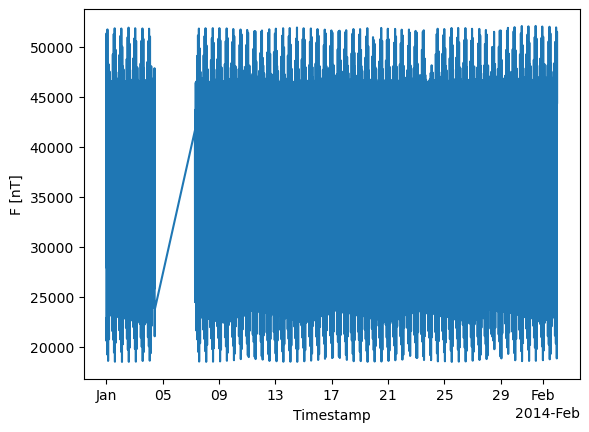

In [15]:
ds["F"].sel(Timestamp=slice("2014-01-01", "2014-02-01")).plot();

In [16]:
!rm data*.nc